# Imports

In [ ]:
import pickle

# --- Manipulação de Dados ---
import pandas as pd
import numpy as np
import os
import re

# --- Usar o Colab ---
from google.colab import drive

# --- Para puxar dataset do kaggle ---
import kagglehub

# --- Pré-processamento de Texto ---
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# --- Baixar recursos do NLTK ---
nltk.download('stopwords')
nltk.download('punkt')

# --- Construção e Avaliação do Modelo (IA) ---
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping # Use the standard Keras EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from transformers import create_optimizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# --- Visualização de Dados ---
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- Configurações Opcionais ---
# --- Definir estilo para os gráficos ---
sns.set_style('whitegrid')
# --- Garante que os gráficos apareçam no notebook ---
%matplotlib inline


print("Bibliotecas importadas com sucesso!")
print("TensorFlow Versão:", tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Bibliotecas importadas com sucesso!
TensorFlow Versão: 2.19.0


In [ ]:
# --- Instala a biblioteca 'transformers' da Hugging Face ---
!pip install transformers -q

# Baixando dataset com Kagglehub

In [ ]:
# --- Baixando o dataset do Kaggle ---
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Baixando o dataset do Kaggle...")

# --- Construindo o caminho completo para o arquivo CSV que está dentro da pasta baixada ---
file_path = os.path.join(path, "Combined Data.csv")

print(f"Caminho do arquivo encontrado: {file_path}")

# --- Lendo o arquivo CSV e carregando conteúdo na variável 'df' ---
df = pd.read_csv(file_path)

print("Carregando dados para o DataFrame...")
print("\n--- Dados carregados com sucesso! ---")
df.head()

100%|██████████| 11.1M/11.1M [00:00<00:00, 24.4MB/s]

Extracting files...


Baixando o dataset do Kaggle...
Caminho do arquivo encontrado: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv
Carregando dados para o DataFrame...

--- Dados carregados com sucesso! ---


,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


# Pré-processamento e Limpeza

In [ ]:
# Removendo colunas irrelevantes
df.drop('Unnamed: 0', axis=1, inplace=True)

# Resultado
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


--- Quantidade de cada status (sentimento) ---
status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


/tmp/ipython-input-485430351.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_sentimentos.index, y=contagem_sentimentos.values, palette='viridis')


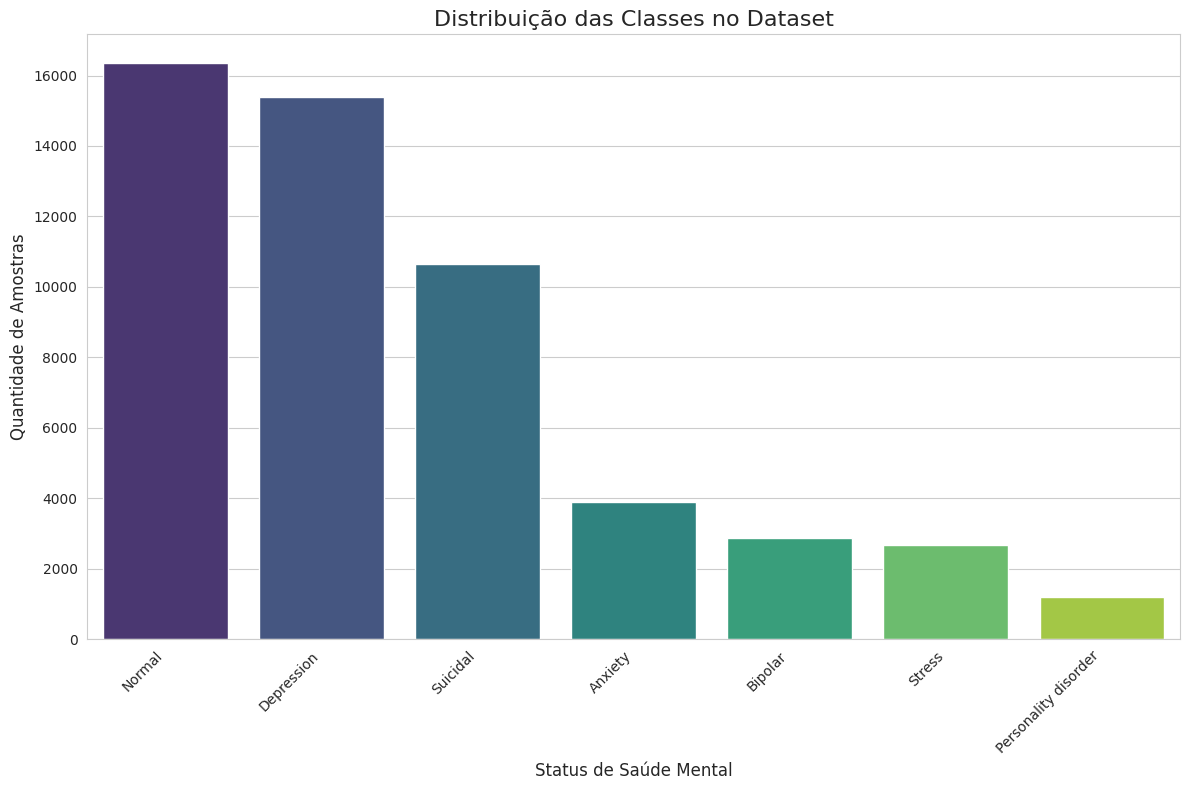

In [ ]:
# --- Análise Quantitativa ---

# Contando a quantidade de cada sentimento
contagem_sentimentos = df['status'].value_counts()

# Exibindo a contagem em formato de tabela
print("--- Quantidade de cada status (sentimento) ---")
print(contagem_sentimentos)

# Criando um gráfico de barras para visualizar
plt.figure(figsize=(12, 8))
sns.barplot(x=contagem_sentimentos.index, y=contagem_sentimentos.values, palette='viridis')
plt.title('Distribuição das Classes no Dataset', fontsize=16)
plt.xlabel('Status de Saúde Mental', fontsize=12)
plt.ylabel('Quantidade de Amostras', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **Mapeamento dos status para numero**

In [ ]:
# Mapeando o rótulo
le = LabelEncoder()
df['status_encoded'] = le.fit_transform(df['status'])
print(df[['status', 'status_encoded']].sample(15))

                     status  status_encoded
19065              Suicidal               6
8176             Depression               2
52044               Anxiety               0
12635              Suicidal               6
10164              Suicidal               6
47995            Depression               2
21105              Suicidal               6
26656            Depression               2
17385            Depression               2
50751  Personality disorder               4
23881            Depression               2
1740                 Normal               3
25260            Depression               2
48370                Stress               5
44039                Normal               3


## **Alterando nome das classes**

In [ ]:
# Renomeando colunas
df.rename(columns={
    'statement': 'texto_completo',
    'status_encoded': 'sentimento'
}, inplace=True)

# Remover a coluna que não usaremos
df.drop(columns=['status'], inplace=True)

print("--- DataFrame após rename de colunas: ---")
df.head()

--- DataFrame após rename de colunas: ---


,texto_completo,sentimento
0,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",0
2,"All wrong, back off dear, forward doubt. Stay ...",0
3,I've shifted my focus to something else but I'...,0
4,"I'm restless and restless, it's been a month n...",0


## **Limpeza**

In [ ]:
def limpar_texto(texto_completo):
    # Garante que o texto seja uma string
    if not isinstance(texto_completo, str):
        return ""

    text = texto_completo

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# 2. Aplicando a função de limpeza na coluna 'texto_completo'
print("\nIniciando a limpeza do texto...")
df['texto_limpo'] = df['texto_completo'].apply(limpar_texto)
print("Limpeza concluída!")

# 3. Verificando o resultado final
print("\n--- Resultado Final da Preparação ---")

df[['texto_completo', 'texto_limpo', 'sentimento']].head()


Iniciando a limpeza do texto...
Limpeza concluída!

--- Resultado Final da Preparação ---


,texto_completo,texto_limpo,sentimento
0,oh my gosh,oh my gosh,0
1,"trouble sleeping, confused mind, restless hear...",trouble sleeping confused mind restless heart ...,0
2,"All wrong, back off dear, forward doubt. Stay ...",all wrong back off dear forward doubt stay in ...,0
3,I've shifted my focus to something else but I'...,ive shifted my focus to something else but im ...,0
4,"I'm restless and restless, it's been a month n...",im restless and restless its been a month now ...,0


# DistilBERT

Carregar o Modelo e o Tokenizer do DistilBERT

In [ ]:

# Nome do modelo
MODEL_NAME = "distilbert-base-uncased"

# 1. Carregar o Tokenizer (isso geralmente não dá problema)
tokenizer_bert = AutoTokenizer.from_pretrained(MODEL_NAME)

# 2. Carregar o Modelo pré-treinado com o argumento de conversão
print("Carregando o modelo DistilBERT e convertendo os pesos...")
model_bert = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=7,
    from_pt=True
)

print("\nModelo DistilBERT e seu tokenizer foram carregados com sucesso!")
model_bert.summary()

Carregando o modelo DistilBERT e convertendo os pesos...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla


Modelo DistilBERT e seu tokenizer foram carregados com sucesso!
Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66958855 (255.43 MB)
Trainable params: 66958855 (255.43 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________

Pré-processamento (Tokenização para o BERT)

In [ ]:
# --- Tokenização para o DistilBERT ---

# Parâmetros
MAX_LENGTH = 120 # Vamos usar um comprimento um pouco maior, comum para BERT

# Pegando os textos e os rótulos
X = df['texto_limpo'].tolist()
y = df['sentimento'].values

# Dividindo os dados ANTES de tokenizar (prática comum com Transformers)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Tokenizando os dados de treino e teste com o tokenizer do DistilBERT
print("Tokenizando os dados para o formato do DistilBERT...")
train_encodings = tokenizer_bert(X_train, truncation=True, padding=True, max_length=MAX_LENGTH)
test_encodings = tokenizer_bert(X_test, truncation=True, padding=True, max_length=MAX_LENGTH)

# Criando datasets no formato do TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

print("Datasets prontos para o treinamento!")

Tokenizando os dados para o formato do DistilBERT...
Datasets prontos para o treinamento!


Compilar

In [ ]:
# --- Compilação ---

# Calcular os pesos de classe (como antes, usando y_train)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# --- Criação do Otimizador Compatível ---
BATCH_SIZE = 16
EPOCHS = 5

# Calcular o número total de passos de treinamento
num_train_steps = len(train_dataset) // BATCH_SIZE * EPOCHS

# Criar o otimizador usando a função da Hugging Face
optimizer, schedule = create_optimizer(
    init_lr=(5e-5), # Taxa de aprendizado inicial
    num_warmup_steps=1, # Passos de aquecimento
    num_train_steps=num_train_steps
)

# Compilar o modelo com o novo otimizador
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

print("Modelo compilado com sucesso!")

Modelo compilado com sucesso!


Treinar Modelo

In [ ]:
# Treinar o modelo
history_bert = model_bert.fit(
    train_dataset.shuffle(1000).batch(BATCH_SIZE),
    epochs=2,
    validation_data=test_dataset.batch(BATCH_SIZE),
    class_weight=class_weight_dict,
)


print("\nTreinamento do DistilBERT concluído!")

Epoch 1/2
2653/2653 [==============================] - 626s 226ms/step - loss: 0.6523 - accuracy: 0.7509 - val_loss: 0.5087 - val_accuracy: 0.7978
Epoch 2/2
2653/2653 [==============================] - 557s 210ms/step - loss: 0.4318 - accuracy: 0.8294 - val_loss: 0.4817 - val_accuracy: 0.8074

Treinamento do DistilBERT concluído!


Checkpoint manual

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# caminho para a pasta no Drive
caminho_drive = '/content/drive/MyDrive/UFPB/P7/IA/'

In [ ]:
# Salva os ficheiros diretamente nessa pasta
model_bert.save_weights(caminho_drive + 'distilbert_model_weights.h5')

# Saving the DistilBERT tokenizer
with open(caminho_drive + 'distilbert_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer_bert, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving the label encoder
with open(caminho_drive + 'label_encoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"\nCheckpoint salvo permanentemente em: {caminho_drive}")


Checkpoint salvo permanentemente em: /content/drive/MyDrive/UFPB/P7/IA/


Para usar o Checkpoint guardado

In [ ]:
# from transformers import create_optimizer # Ensure this is imported if not already in the first cell - Removed this import

print("\nA carregar as ferramentas guardadas...")
# Carregar o Tokenizer
with open(caminho_drive + 'distilbert_tokenizer.pickle', 'rb') as handle:
    tokenizer_bert = pickle.load(handle)

# Carregar o LabelEncoder
with open(caminho_drive + 'label_encoder.pickle', 'rb') as handle:
    le = pickle.load(handle)

print("   - Tokenizer e LabelEncoder carregados com sucesso!")

# Reconstruir a Arquitetura do Modelo e Carregar os Pesos ---
print("\nA reconstruir a arquitetura do modelo...")

# crucial recriar o modelo com a mesma configuração (ex: num_labels=7)
MODEL_NAME = "distilbert-base-uncased"
model_carregado = TFAutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=7,
    from_pt=True # Importante para compatibilidade
)


BATCH_SIZE_LOAD = 16 # Use the batch size from the original training
EPOCHS_LOAD = 4 # Use the total epochs from the original training


# Use the previously calculated num_train_steps
optimizer, schedule = create_optimizer(
    init_lr=(5e-5),  # Initial learning rate
    num_warmup_steps=1,  # Warmup steps
    num_train_steps=num_train_steps # Reuse the previously calculated steps
)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_carregado.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Agora, carregar os pesos que guardou
print("A carregar os pesos guardados...")
model_carregado.load_weights(caminho_drive + 'distilbert_model_weights.h5')

print("\n--- Modelo pronto para ser usado! ---")

# Agora o 'model_carregado' está exatamente como ele era no final da época salva,
# pronto para ser avaliado ou usado para previsões.


A carregar as ferramentas guardadas...
   - Tokenizer e LabelEncoder carregados com sucesso!

A reconstruir a arquitetura do modelo...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'cla

A carregar os pesos guardados...

--- Modelo pronto para ser usado! ---


> Avaliações do modelo

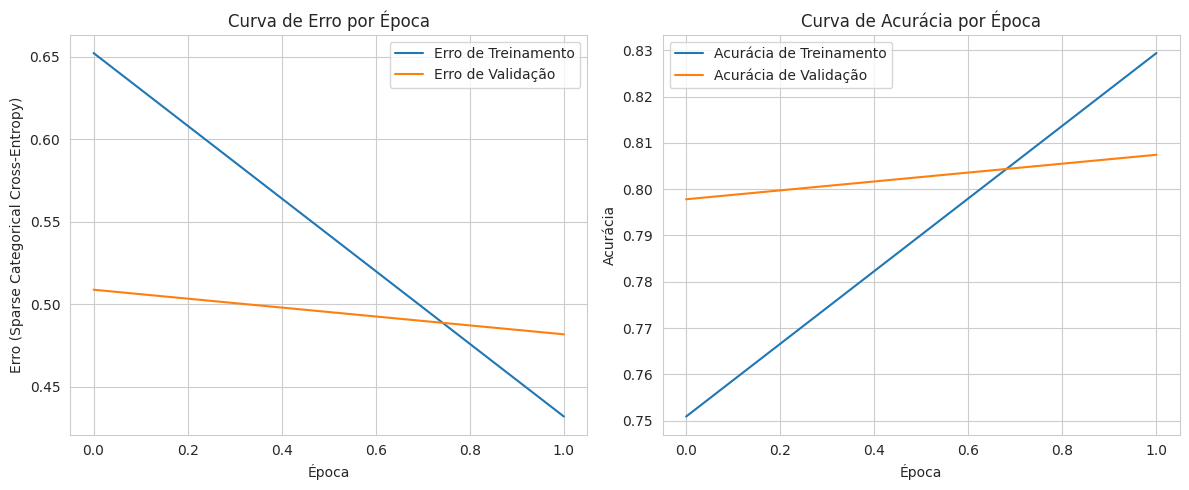


--- Avaliando o modelo no conjunto de teste ---
664/664 [==============================] - 46s 70ms/step - loss: 0.4817 - accuracy: 0.8074

Erro (Loss) no conjunto de teste: 0.4817
Acurácia do modelo no conjunto de teste: 80.74%


In [ ]:
# AVALIAÇÃO MODELO

# Plotando as curvas de Erro (Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Pimeiro gráfico em uma figura com 2 subplots
plt.plot(history_bert.history['loss'], label='Erro de Treinamento')
plt.plot(history_bert.history['val_loss'], label='Erro de Validação')
plt.title('Curva de Erro por Época')
plt.xlabel('Época')
plt.ylabel('Erro (Sparse Categorical Cross-Entropy)') # <-- RÓTULO
plt.legend()
plt.grid(True)

# Plotando as curvas de Acurácia
plt.subplot(1, 2, 2) # Cria o segundo gráfico
plt.plot(history_bert.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history_bert.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Curva de Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)

plt.tight_layout() # Ajusta o espaçamento entre os gráficos
plt.show()

# Avaliação final no conjunto de teste
print("\n--- Avaliando o modelo no conjunto de teste ---")
loss, accuracy = model_bert.evaluate(test_dataset.batch(BATCH_SIZE), verbose=1)
print(f"\nErro (Loss) no conjunto de teste: {loss:.4f}")
print(f"Acurácia do modelo no conjunto de teste: {accuracy*100:.2f}%")

Matriz de Confusão

Fazendo previsões no conjunto de teste...
10609/10609 [==============================] - 67s 6ms/step
Gerando a matriz de confusão...


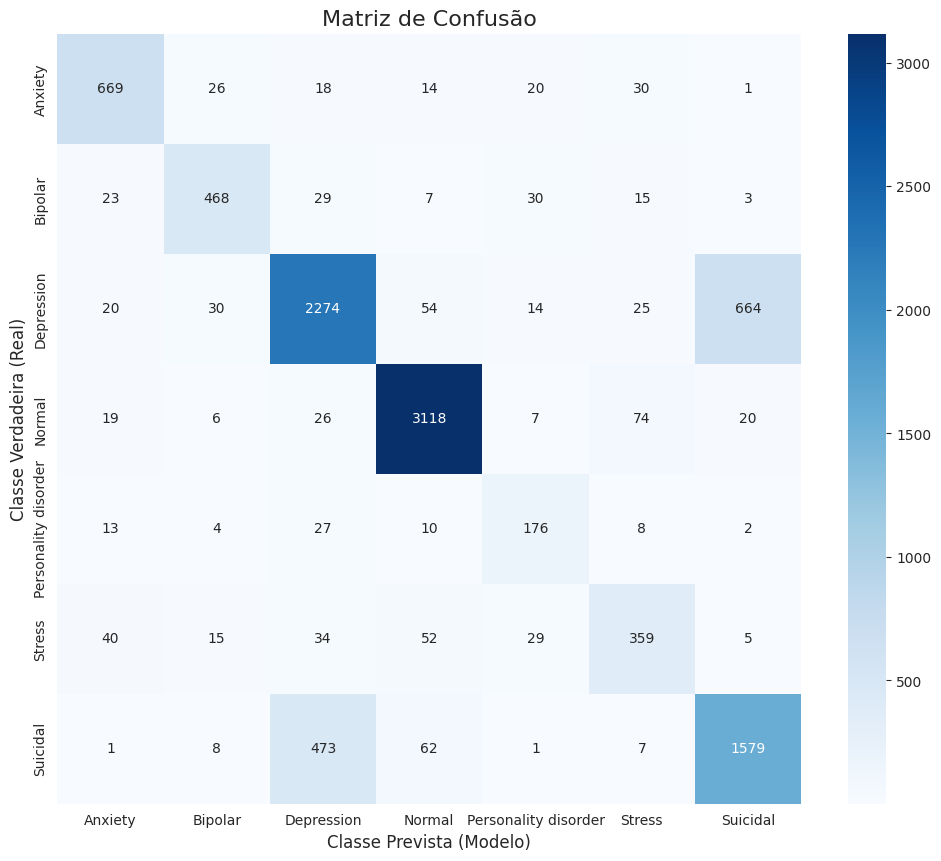

In [ ]:
# --- MATRIZ DE CONFUSÃO

# Fazer as previsões no conjunto de teste
print("Fazendo previsões no conjunto de teste...")
y_pred_probs = model_carregado.predict(test_dataset).logits # Access logits
y_pred = np.argmax(y_pred_probs, axis=1) # Pega a classe com maior probabilidade

# Calcular a matriz de confusão com os números brutos
cm = confusion_matrix(y_test, y_pred)

# Visualizar a matriz normalizada com um heatmap
print("Gerando a matriz de confusão...") # Updated print statement
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # Changed fmt to 'd' for integers and using cm
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.title('Matriz de Confusão', fontsize=16) # Updated title
plt.ylabel('Classe Verdadeira (Real)', fontsize=12)
plt.xlabel('Classe Prevista (Modelo)', fontsize=12)
plt.show()

Matriz normalizada

10609/10609 [==============================] - 71s 7ms/step


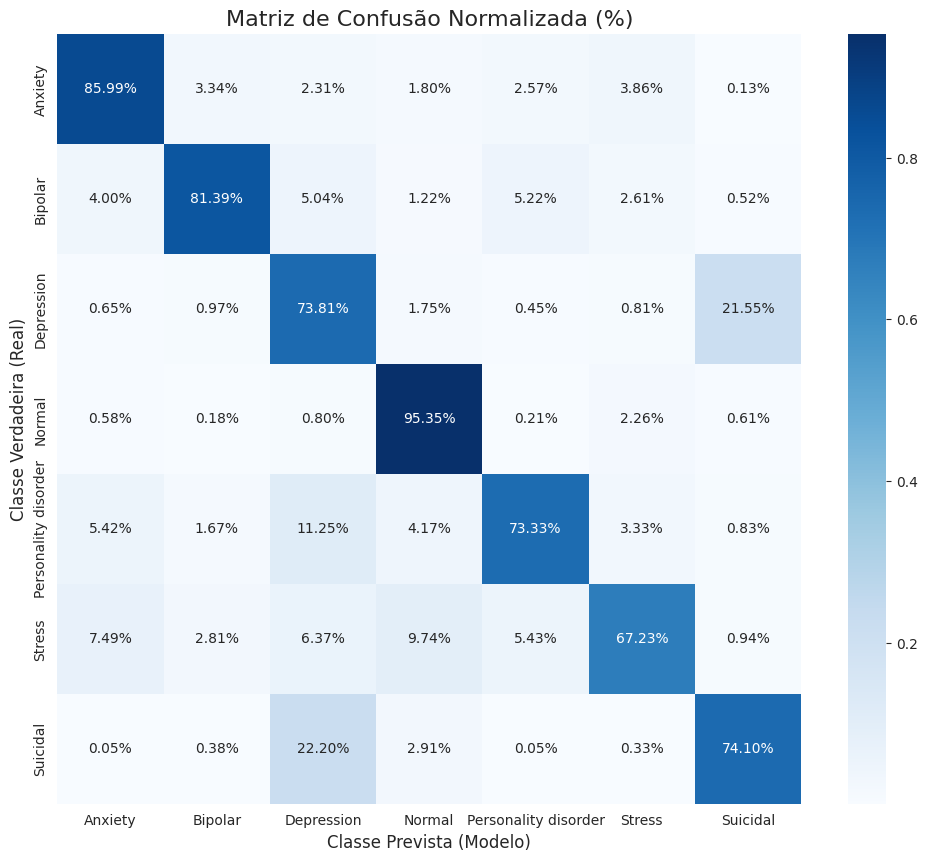

In [ ]:
# Fazer as previsões (se ainda não tiver feito)
y_pred_probs = model_carregado.predict(test_dataset)
y_pred = np.argmax(y_pred_probs.logits, axis=1)

# Calcular a matriz de confusão bruta
cm = confusion_matrix(y_test, y_pred)

# Normalizar a matriz pelas linhas
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualizar a matriz normalizada
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.title('Matriz de Confusão Normalizada (%)', fontsize=16)
plt.ylabel('Classe Verdadeira (Real)', fontsize=12)
plt.xlabel('Classe Prevista (Modelo)', fontsize=12)
plt.show()

Relatório de classificação

In [ ]:
# Relatório de classificação
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("--- Relatório de Classificação por Classe ---")
print(report)

--- Relatório de Classificação por Classe ---
                      precision    recall  f1-score   support

             Anxiety       0.85      0.86      0.86       778
             Bipolar       0.84      0.81      0.83       575
          Depression       0.79      0.74      0.76      3081
              Normal       0.94      0.95      0.95      3270
Personality disorder       0.64      0.73      0.68       240
              Stress       0.69      0.67      0.68       534
            Suicidal       0.69      0.74      0.72      2131

            accuracy                           0.81     10609
           macro avg       0.78      0.79      0.78     10609
        weighted avg       0.82      0.81      0.81     10609



In [ ]:
# --- PREDIÇÕES ALEATÓRIAS ---

# Para buscar o texto original, precisamos refazer a divisão incluindo a coluna de texto
print("Preparando os textos para exibição...")
# We already have X_test and y_test from the DistilBERT preprocessing step
# We also have the original texts in the X_test list

# Criando o mapeamento de número para texto (caso não exista nesta sessão)
label_mapping = dict(zip(le.transform(le.classes_), le.classes_))


print("\n--- Exemplos de Predições Aleatórias ---")

# Seleciona 5 índices aleatórios do conjunto de teste
indices_aleatorios = np.random.choice(len(X_test), 5, replace=False)

# Itera sobre os índices selecionados
for index in indices_aleatorios:
    texto_original = X_test[index] # Use X_test list for original text
    rotulo_verdadeiro_num = y_test[index]
    rotulo_verdadeiro_texto = label_mapping[rotulo_verdadeiro_num]

    # Prepare the sample for the model (using the test_dataset structure)
    # Need to get the encoding for the specific index from test_dataset
    # This requires iterating through the dataset or creating a temporary dataset for the sample
    # A simpler approach is to re-tokenize the single text for prediction

    # Re-tokenize the single text for prediction
    amostra_para_prever = tokenizer_bert(
        [texto_original], # Pass as a list
        truncation=True,
        padding=True,
        max_length=MAX_LENGTH,
        return_tensors="tf" # Return TensorFlow tensors
    )

    # Make the prediction using the bert model
    predicao_probs = model_carregado.predict(amostra_para_prever, verbose=0).logits[0] # Access logits

    # Pega o índice da classe com maior probabilidade
    rotulo_previsto_num = np.argmax(predicao_probs)
    rotulo_previsto_texto = label_mapping[rotulo_previsto_num]

    # A confiança é a probabilidade máxima (after applying softmax if needed, but logit values are fine for argmax)
    # To get actual probabilities, apply softmax
    confianca = tf.nn.softmax(predicao_probs).numpy().max()


    print(f"\nTEXTO: '{texto_original}'\n")
    print(f"    - ✅ Rótulo Verdadeiro: {rotulo_verdadeiro_texto}")
    print(f"    - 🤖 Predição do Modelo: {rotulo_previsto_texto} (Confiança: {confianca:.2%})")
    print("-" * 50)

Preparando os textos para exibição...

--- Exemplos de Predições Aleatórias ---

TEXTO: 'your responses to the survey items will be anonymous and kept confidential clicking the survey link below will take you to a page asking you to read through a consent form explaining the purpose of this research the content of the survey the type of questions you will be asked the amount of time it may take to complete the survey and the risks and benefits of your participation at the end of the form you can click agree to consent to the use of the answers you provide and to begin completing the survey thank you for your time and interest'

    - ✅ Rótulo Verdadeiro: Normal
    - 🤖 Predição do Modelo: Normal (Confiança: 98.66%)
--------------------------------------------------

TEXTO: 'is there a point in trying to completely get over this shit i try so hard to get close to people and basically no ones ever responsive and literally no one gives more than baseline politeness i expend so much energy

Teste em Usuário do Twitter

Analisando 13 tweets...

Tweet: 'When I don't work out I feel so bad, I get stressed, my self-esteem is low, among other things. Yes, I'm addicted to endorphins.
' - Previsão: Stress (Confiança: 72.77%)

Tweet: 'This university is killing me, I'm doing so poorly psychologically.
' - Previsão: Normal (Confiança: 45.22%)

Tweet: 'Just when you think you'll have some money 'left over' this month, then a bunch of things run out all at once.
' - Previsão: Normal (Confiança: 97.15%)

Tweet: 'The weekend went by at the speed of light, oh I hate it.
' - Previsão: Normal (Confiança: 99.67%)

Tweet: 'Oh boy, I want to cry.
' - Previsão: Normal (Confiança: 99.42%)

Tweet: 'The only bad thing about working out early in the morning is having to wake up early, but afterwards you get that feeling of accomplishment, and you worry less about 'oh my god, what time am I going to work out...'. Not to mention you have more energy during the day. Sooo good.
' - Previsão: Anxiety (Confiança: 76.54%)

Tweet: 

/tmp/ipython-input-4150908552.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_previsoes.index, y=contagem_previsoes.values, palette='viridis')


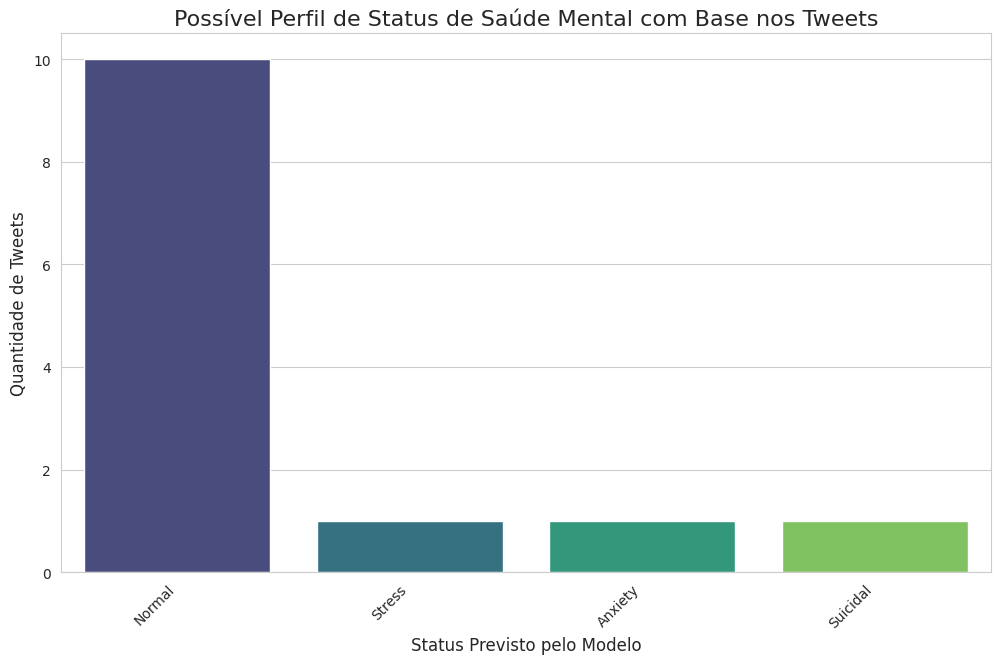

In [ ]:
def analisar_perfil_usuario(lista_de_tweets, model, tokenizer, label_encoder):
    """
    Recebe uma lista de tweets, classifica cada um, e exibe um resumo
    e um gráfico com a distribuição das previsões.
    """
    print(f"Analisando {len(lista_de_tweets)} tweets...")

    previsoes = []
    confiancas = []

    # 1. Classificar cada tweet na lista
    for tweet in lista_de_tweets:
        texto_limpo = limpar_texto(tweet)
        # Use the DistilBERT tokenizer directly
        encoded_input = tokenizer(
            [texto_limpo], # Pass as a list
            truncation=True,
            padding=True,
            max_length=MAX_LENGTH,
            return_tensors="tf" # Return TensorFlow tensors
        )

        # Predict using the provided model (should be model_carregado)
        predicao_probs = model.predict(encoded_input, verbose=0).logits[0]

        indice_previsto = np.argmax(predicao_probs)
        # Use softmax to get probabilities for confidence score
        confianca = tf.nn.softmax(predicao_probs).numpy().max()
        nome_classe = label_encoder.inverse_transform([indice_previsto])[0]

        previsoes.append(nome_classe)
        confiancas.append(confianca)
        print(f"\nTweet: '{tweet}\n' - Previsão: {nome_classe} (Confiança: {confianca:.2%})")

    # 2. Analisar e exibir os resultados
    print("\n--- Análise do Perfil Concluída ---")

    # Criar um DataFrame com os resultados para fácil análise
    df_resultados = pd.DataFrame({
        'tweet': lista_de_tweets,
        'previsao': previsoes,
        'confianca': confiancas
    })

    # Calcular a contagem de cada previsão
    contagem_previsoes = df_resultados['previsao'].value_counts()

    print("\nDistribuição das Classificações:")
    print(contagem_previsoes)

    # 3. Gerar o gráfico de barras
    plt.figure(figsize=(12, 7))
    sns.barplot(x=contagem_previsoes.index, y=contagem_previsoes.values, palette='viridis')
    plt.title('Possível Perfil de Status de Saúde Mental com Base nos Tweets', fontsize=16)
    plt.xlabel('Status Previsto pelo Modelo', fontsize=12)
    plt.ylabel('Quantidade de Tweets', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.show()

# --- TESTANDO A FUNÇÃO ---

tweets_de_um_usuario_exemplo = [
    "When I don't work out I feel so bad, I get stressed, my self-esteem is low, among other things. Yes, I'm addicted to endorphins.",
    "This university is killing me, I'm doing so poorly psychologically.",
    "Just when you think you'll have some money 'left over' this month, then a bunch of things run out all at once.",
    "The weekend went by at the speed of light, oh I hate it.",
    "Oh boy, I want to cry.",
    "The only bad thing about working out early in the morning is having to wake up early, but afterwards you get that feeling of accomplishment, and you worry less about 'oh my god, what time am I going to work out...'. Not to mention you have more energy during the day. Sooo good.",
    "Everyone's voice is irritating me today.",
    "The sun is already scorching at this hour, I just wanted a little time at the beach.",
    "I can't stop to think because only nonsense comes to mind.",
    "I really wanted to speak out about this, ugh.",
    "Boy, if I got 6 hours of sleep from Monday until today, that was a lot. End of the semester is chaos.",
    "I wish I was 'paranoid', counting calories and policing myself (a little), at least I was looking good and feeling good about my body.",
    "To be a Corinthians fan, you have to understand and accept that you have a higher chance of having a heart attack."
]

# Chamar a função com a lista de tweets and the loaded model and tokenizer
# Use model_carregado instead
analisar_perfil_usuario(tweets_de_um_usuario_exemplo, model_carregado, tokenizer_bert, le)